In [1]:
import argparse
import glob
import os
import pathlib
import _pickle

import autograd.numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

import phlearn.phsystems as phsys
import phlearn.phnns as phnn

from scipy.integrate import solve_ivp
from scipy.sparse import diags

torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False
ttype = torch.float32
torch.set_default_dtype(ttype)
%matplotlib notebook
custom_colors = sns.color_palette([(1,0.7,0.3), (0.2,0.7,0.2), (0.8,0,0.2), (0.6,0.8,.8), (0,0.4,1), (0.5,0.3,.5)])
sns.set_palette(custom_colors)

plot_settings = {
    'axes.prop_cycle': mpl.cycler(color=custom_colors),
    'text.usetex': True,
    'font.family': 'serif',
    'axes.titlesize': 9,
    'figure.titlesize': 9,
    'legend.title_fontsize': 8,
    'axes.labelsize': 9,
    'font.size': 9,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'xtick.major.size': 8,
    'ytick.major.size': 8,
    'savefig.dpi': 300,
}


plt.rcParams.update(plot_settings)

In [2]:
modelfolder = 'trained_models_pm_integrators/'
df = pd.DataFrame(columns=['system_type', 'baseline', 'ntrainingpoints', 'sampling_time', 't_max', 'integrator',
                           'F_timedependent', 'F_spacedependent', 'F_statedependent', 'pHnn_model', 'val_loss'])
for f in glob.glob(modelfolder+"/*"):
    if ('DS_store' not in f) and ('.csv' not in f):
        model, optimizer, metadict = phnn.load_dynamic_system_model(f)
        #print('metadict[traininginfo]:', metadict['traininginfo'].keys())
        df.loc[f[30:]] = {'system_type': metadict['traininginfo']['system'],
                                   'baseline': int(metadict['traininginfo']['baseline']),
                                   'ntrainingpoints': metadict['traininginfo']['ntrainingpoints'],
                                   'sampling_time': metadict['traininginfo']['sampling_time'],
                                   't_max': metadict['traininginfo']['t_max'],
                                   'integrator': metadict['traininginfo']['integrator'],
                                   'F_timedependent': bool(metadict['traininginfo']['F_timedependent']),
                                   'F_spacedependent': bool(metadict['traininginfo']['F_spacedependent']),
                                   'F_statedependent': bool(metadict['traininginfo']['F_statedependent']),
                                   'val_loss': metadict['traininginfo']['val_loss'],
                                   'pHnn_model': model}

In [3]:
dt_rollout = 0.0002
extrapolate = False
t_max = .02
dt = 0.02
result_file = f'testresults_dt{dt_rollout:.0e}_n10_t{int(t_max)}.csv'
t_max = 1
stored_results_path = os.path.join(modelfolder, result_file)
stored_df = pd.read_csv(stored_results_path, index_col=0)

df.loc[stored_df.index, stored_df.columns] = stored_df.loc[stored_df.index, :].values.copy()

In [4]:
df = df[df['sampling_time'] == dt]
df['MSE'] = df['MSE']
df['Model type'] = df['baseline'].astype(int)
df['Model type'] = df['Model type'].map({1:'Baseline (1NN)', 2:'Baseline (2NN)',
                                         3:'PHNN (general)', 0:'PHNN (informed)'})
df['integrator'] = df['integrator'].map({'midpoint':'Midpoint', 'srk4':'SRK4'})
#df['integrator'] = df['integrator'].map({'midpoint':'Midpoint'})
type_order = ['1N baseline', '2N baseline', 'PHNN (general)', 'PHNN (informed)']

In [5]:
df

,system_type,baseline,ntrainingpoints,sampling_time,t_max,integrator,F_timedependent,F_spacedependent,F_statedependent,pHnn_model,val_loss,MSE,MSE endtime,Model type
20230419180053176288.model,pm,3,10,0.02,0.02,Midpoint,False,True,False,ConservativeDissipativeNN(\n (external_forces...,12.063256,0.000711,0.001051,PHNN (general)
20230419180042192577.model,pm,3,10,0.02,0.02,Midpoint,False,True,False,ConservativeDissipativeNN(\n (external_forces...,12.760333,0.000890,0.001134,PHNN (general)
20230419180019592766.model,pm,3,10,0.02,0.02,Midpoint,False,True,False,ConservativeDissipativeNN(\n (external_forces...,10.552007,0.000616,0.000618,PHNN (general)
20230419175532198977.model,pm,3,10,0.02,0.02,SRK4,False,True,False,ConservativeDissipativeNN(\n (external_forces...,7.915407,0.000203,0.000355,PHNN (general)
20230419180054967422.model,pm,3,10,0.02,0.02,SRK4,False,True,False,ConservativeDissipativeNN(\n (external_forces...,6.651168,0.000191,0.000307,PHNN (general)
20230419175411928476.model,pm,3,10,0.02,0.02,SRK4,False,True,False,ConservativeDissipativeNN(\n (external_forces...,8.078216,0.000211,0.000371,PHNN (general)
20230419180015441399.model,pm,3,10,0.02,0.02,SRK4,False,True,False,ConservativeDissipativeNN(\n (external_forces...,7.803971,0.000217,0.000400,PHNN (general)
20230419175303939463.model,pm,3,10,0.02,0.02,Midpoint,False,True,False,ConservativeDissipativeNN(\n (external_forces...,12.375588,0.000510,0.000440,PHNN (general)


In [6]:
#df = df[:2]

In [7]:
x_max = 6
x_points = 300
dx = x_max/x_points
x = np.linspace(0,x_max-dx,x_points)
def F(u, t):
    return 10*np.sin(2*2*np.pi/x_max*x)
def JF(u,t):
    return np.zeros((u.shape[0],u.shape[0]))
PDE_system = phsys.PeronaMalikSystem(x=x, force=F, force_jac=JF,
                                 init_sampler=phsys.initial_condition_pm(x))

In [8]:
t_max = .02
a = 1
d1, d2 = 1., 2.
k1, k2 = 2., 15.
n1, n2 = 30., 0.15
P = (x[-1]-x[0])*x.size/(x.size-1)
u0 = a - np.tanh(n1*(x-d1)) + np.tanh(n1*(x-x_max+d1))
u0 += - np.tanh(n1*(x-d2)) + np.tanh(n1*(x-x_max+d2))
u0 += n2*np.sin(k1*np.pi*x)**2*np.sin(k2*np.pi*x)

bestmodels = []
for modeltype, grp in df.groupby('Model type'):
    bestmodelstats = grp.sort_values('MSE').iloc[0]
    bestmodel, _, bestmodel_metadict = phnn.load_dynamic_system_model(modelfolder+'/'+bestmodelstats.name)
    bestmodels += [(bestmodel, bestmodelstats, bestmodel_metadict, modeltype)]

In [9]:
seed = 20
PDE_system.seed(seed)
x = PDE_system.x
u_exact_orig, dudt, t_sample, _ = PDE_system.sample_trajectory(np.arange(0, t_max+dt_rollout, dt_rollout), x0=u0)
N = t_sample.shape[0]-1

In [10]:
model_solutions_original = []
for pHnn_model, modelstats, modeldict, modeltype in bestmodels:
    u_model, _ = pHnn_model.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
    model_solutions_original.append((u_model, modeltype, 'Original'))

In [11]:
u_max, u_min = u_exact_orig.max(), u_exact_orig.min()
for (u, _, _) in model_solutions_original:
    if u.max() > u_max:
        u_max = u.max()
    if u.min() < u_min:
        u_min = u.min()
#u_min = max(u_min, -2)
#u_max = min(u_max, 10)

# N = t_sample.shape[0]-1
# u0 = u_exact_orig[0, :]
# fig = plt.figure(figsize=(8, 1.6))
# ax1 = fig.add_subplot(1, 3, 1)
# col = 2
# ax1.set_title('Initial value')
# ax1.plot(x, u_exact_orig[0,:], color='k', linestyle='--', linewidth=1)
# ax1.set_ylim([1.1*u_min, 1.1*u_max])
# ax1.set_ylabel('$u$')
# ax1.set_xlabel('$x$')
# for i in range(1,3):
#     ax1 = fig.add_subplot(1, 3, col)
#     ax1.set_title(f'$t = {i/2*t_max}$')
#     for j, (u, modeltype, _) in enumerate(model_solutions_original):
#         ax1.plot(x, u[int(i*N/2),:], color=custom_colors[j], linewidth=1, label=modeltype) 
#     ax1.plot(x, u_exact_orig[int(i*N/2),:], color='k', linestyle='--', linewidth=1, label='Ground truth')
#     ax1.set_xlabel('$x$')
#     ax1.set_yticks([])
#     ax1.set_ylim([1.1*u_min, 1.1*u_max])
#     col += 1
# ax1.legend(bbox_to_anchor=(-0.6, -0.34), loc='upper center', ncol=5, fancybox=True)
# #fig.tight_layout()
# fig.subplots_adjust(wspace=0.1)
# fig.savefig('figs/paper/pm_time.pdf', bbox_inches='tight')

In [12]:
df[df['Model type']=='PHNN (general)']

,system_type,baseline,ntrainingpoints,sampling_time,t_max,integrator,F_timedependent,F_spacedependent,F_statedependent,pHnn_model,val_loss,MSE,MSE endtime,Model type
20230419180053176288.model,pm,3,10,0.02,0.02,Midpoint,False,True,False,ConservativeDissipativeNN(\n (external_forces...,12.063256,0.000711,0.001051,PHNN (general)
20230419180042192577.model,pm,3,10,0.02,0.02,Midpoint,False,True,False,ConservativeDissipativeNN(\n (external_forces...,12.760333,0.000890,0.001134,PHNN (general)
20230419180019592766.model,pm,3,10,0.02,0.02,Midpoint,False,True,False,ConservativeDissipativeNN(\n (external_forces...,10.552007,0.000616,0.000618,PHNN (general)
20230419175532198977.model,pm,3,10,0.02,0.02,SRK4,False,True,False,ConservativeDissipativeNN(\n (external_forces...,7.915407,0.000203,0.000355,PHNN (general)
20230419180054967422.model,pm,3,10,0.02,0.02,SRK4,False,True,False,ConservativeDissipativeNN(\n (external_forces...,6.651168,0.000191,0.000307,PHNN (general)
20230419175411928476.model,pm,3,10,0.02,0.02,SRK4,False,True,False,ConservativeDissipativeNN(\n (external_forces...,8.078216,0.000211,0.000371,PHNN (general)
20230419180015441399.model,pm,3,10,0.02,0.02,SRK4,False,True,False,ConservativeDissipativeNN(\n (external_forces...,7.803971,0.000217,0.000400,PHNN (general)
20230419175303939463.model,pm,3,10,0.02,0.02,Midpoint,False,True,False,ConservativeDissipativeNN(\n (external_forces...,12.375588,0.000510,0.000440,PHNN (general)


In [13]:
bestmodels_integrator = []
for integrator, grp in df[df['Model type']=='PHNN (general)'].groupby('integrator'):
    bestmodelstats = grp.sort_values('MSE').iloc[0]
    bestmodel, _, bestmodel_metadict = phnn.load_dynamic_system_model(modelfolder+'/'+bestmodelstats.name)
    bestmodels_integrator += [(bestmodel, bestmodelstats, bestmodel_metadict, integrator)]

In [14]:
model_solutions_integrators = []
for pHnn_model, modelstats, modeldict, integrator in bestmodels_integrator:
    u_model, _ = pHnn_model.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
    model_solutions_integrators.append((u_model, integrator, 'Original'))

In [15]:
# u_max, u_min = u_exact_orig.max(), u_exact_orig.min()
# for (u, _, _) in model_solutions_integrators:
#     if u.max() > u_max:
#         u_max = u.max()
#     if u.min() < u_min:
#         u_min = u.min()
# #u_min = max(u_min, -2)
# #u_max = min(u_max, 10)

# N = t_sample.shape[0]-1
# u0 = u_exact_orig[0, :]
# fig = plt.figure(figsize=(8, 2.))
# ax1 = fig.add_subplot(2, 5, 1)
# col = 2
# ax1.set_title('Initial value')
# ax1.plot(x, u_exact_orig[0,:], color='k', linestyle='-', linewidth=1)
# ax1.set_ylim([1.1*u_min, 1.1*u_max])
# ax1.set_ylabel('$u$')
# ax1.set_xticks([])
# ax1 = fig.add_subplot(2, 5, 6)
# ax1.plot(x, u_exact_orig[0,:], color='k', linestyle='-', linewidth=1)
# ax1.set_ylim([1.1*u_min, 1.1*u_max])
# ax1.set_ylabel('$u$')
# ax1.set_xlabel('$x$')
# for i in range(1,5):
#     for j, (u, integrator, _) in enumerate(model_solutions_integrators):
#         ax1 = fig.add_subplot(2, 5, 5*j+col)
#         if j == 0:
#             ax1.set_xticks([])
#             ax1.set_title(f'$t = {i/4*t_max}$')
#         #if modeltype=='PHNN (general)':
#         ax1.plot(x, u[int(i*N/4),:], color=custom_colors[j], linewidth=1, label=integrator) 
#         ax1.plot(x, u_exact_orig[int(i*N/4),:], color='k', linestyle='--', linewidth=1, label='Ground truth')
#         ax1.set_yticks([])
#         ax1.set_ylim([1.1*u_min, 1.1*u_max])
#     ax1.set_xlabel('$x$')
#     col += 1
# ax1.legend(bbox_to_anchor=(-1.63, -0.55), loc='upper center', ncol=5, fancybox=True)
# #fig.tight_layout()
# fig.subplots_adjust(wspace=0.1)
# fig.savefig('figs/paper/pm_integrators.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


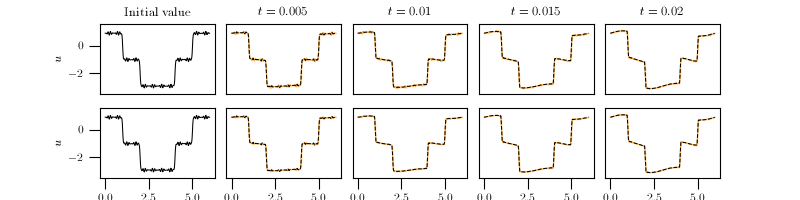

In [19]:
u_max, u_min = u_exact_orig.max(), u_exact_orig.min()
for (u, _, _) in model_solutions_integrators:
    if u.max() > u_max:
        u_max = u.max()
    if u.min() < u_min:
        u_min = u.min()
#u_min = max(u_min, -2)
#u_max = min(u_max, 10)

integrators = ['Midpoint', 'SRK4']

lw = 0.75
N = t_sample.shape[0]-1
u0 = u_exact_orig[0, :]
fig = plt.figure(figsize=(8, 2.))
ax1 = fig.add_subplot(2, 5, 1)
col = 2
ax1.set_title('Initial value')
ax1.plot(x, u_exact_orig[0,:], color='k', linestyle='-', linewidth=lw)
ax1.set_ylim([-3.6, 1.7])
ax1.set_ylabel('$u$')
ax1.set_xticks([])
ax1 = fig.add_subplot(2, 5, 6)
ax1.plot(x, u_exact_orig[0,:], color='k', linestyle='-', linewidth=lw)
ax1.set_ylim([-3.6, 1.7])
ax1.set_ylabel('$u$')
ax1.set_xlabel('$x$')
#for j, (u, integrator, _) in enumerate(model_solutions_integrators):
for j, nt in enumerate(integrators):
    #plotdf = df[df['integrator']==nt].copy()
    grp = df[df['integrator']==nt]
    u_phnn = np.zeros((grp.shape[0], t_sample.shape[0], PDE_system.nstates))
    mse = 0
    for k, modelpath in enumerate(grp.index):
        pHnn_model, _, metadict = phnn.load_dynamic_system_model(modelfolder+'/'+modelpath)
        u_phnn[k], _ = pHnn_model.simulate_trajectory(False, t_sample, x0=u0, xspatial=x)
        #mse += np.mean((u_exact - u_phnn[k])**2)
    meansim = np.mean(u_phnn, axis=0)
    stdsim = np.std(u_phnn, axis=0, ddof=1)
    for i in range(1,5):
        ax1 = fig.add_subplot(2, 5, 5*j+i+1)
        if j == 0:
            ax1.set_xticks([])
            ax1.set_title(f'$t = {i/4*t_max}$')
        #if modeltype=='PHNN (general)':
        #ax1.plot(x, u[int(i*N/4),:], color=custom_colors[j], linewidth=1, label=integrator)
        l = ax1.plot(x, meansim[int(i*N/4),:], label=integrator, color=custom_colors[0], alpha=1., linewidth=lw)
        ax1.fill_between(x, meansim[int(i*N/4),:]-stdsim[int(i*N/4),:],
                         meansim[int(i*N/4),:]+stdsim[int(i*N/4),:], alpha=0.2, color=l[0].get_color())
        ax1.plot(x, meansim[int(i*N/4),:], label=integrator, color=custom_colors[0], alpha=1., linewidth=lw)
        ax1.plot(x, u_exact_orig[int(i*N/4),:], color='k', linestyle='--', label='Ground truth', linewidth=lw)
        ax1.set_yticks([])
        ax1.set_ylim([-3.6, 1.7])
        if j > 0:
            ax1.set_xlabel('$x$')
#ax1.legend(bbox_to_anchor=(-1.63, -0.55), loc='upper center', ncol=5, fancybox=True)
#fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
fig.savefig('figs/paper/pm_integrators_std.pdf', bbox_inches='tight')